In [1]:
# import all packages
import numpy as np



#Helper function packages
import glob
import os
import shutil
from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
#Helper Functions

# reading .npz files 

def get_all_files(directory):
    npz_files = glob.glob(f"{directory}/*.npz")
    names = []  # To store file names

    for npz_file in npz_files:
        names.append(os.path.basename(npz_file))

        # read_npz(npz_file)

def read_npz(npz_file):
    
    # Load the .npz file and extract data, as per your example
    try:
        with np.load(npz_file) as data:
            atom_pos = data['atom_pos']
            # You can also access these if needed later:
            atomic_numbers = data['atomic_numbers']
            # frequencies = data['frequencies']
            # spectrums = data['spectrums']
            
    except Exception as e:
        print(f"Error processing {os.path.basename(npz_file)}: {e}")

    return atom_pos, atomic_numbers


def read_fchk(fchk_file):
    atomic_numbers = []
    coordinates = []
    num_atoms = 0

    with open(fchk_file, 'r') as f:
        lines = f.readlines()

        for i, line in enumerate(lines):
            if line.startswith('Number of atoms'):
                num_atoms = int(line.split()[-1])
            elif line.startswith('Atomic numbers'):
                start_line = i + 1
                values = []
                while len(values) < num_atoms and start_line < len(lines):
                    values.extend([int(x) for x in lines[start_line].split()])
                    start_line += 1
                atomic_numbers = values[:num_atoms]
            elif line.startswith('Current cartesian coordinates'):
                start_line = i + 1
                values = []
                while len(values) < 3 * num_atoms and start_line < len(lines):
                    values.extend([float(x) for x in lines[start_line].split()])
                    start_line += 1
                coordinates = values[:3 * num_atoms]
    
    
    coordinates = np.array(coordinates).reshape(num_atoms, 3)
    #xyz = np.column_stack((coordinates, atomic_numbers))
    return coordinates, atomic_numbers






In [3]:
# Molecular visualization


def get_element_color(atomic_number):
    """Returns a color based on atomic number."""
    # Map atomic numbers to colors (same as original but keyed by number)
    color_map = {
        1: 'lightgray',  # Hydrogen
        2: 'cyan',       # Helium
        3: 'purple',     # Lithium
        4: 'brown',      # Beryllium
        5: 'pink',       # Boron
        6: 'black',      # Carbon
        7: 'blue',       # Nitrogen
        8: 'red',        # Oxygen
        9: 'green',      # Fluorine
        10: 'orange'     # Neon
    }
    return color_map.get(atomic_number, 'gray')  # Default color for unknown elements

def molecule_visualization_image(atom_pos, atomic_numbers, bond_threshold=1.6, axes=None, fchk = False):
    """
    Creates a scatter plot visualization of a molecule with element-based colors and bonds.
    
    Parameters:
    - atom_pos: List or array of [x, y, z] coordinates for each atom.
    - atomic_numbers: List of atomic numbers (integers) for each atom.
    - bond_threshold: Maximum distance (in units of atom_pos) for drawing bonds.
    - axes: Matplotlib axes object to plot on. If None, a new figure and axes are created.
    - fchk: If True, fchk file is read. Otherwise .npz files are read. 
    """
    # Define mapping from atomic numbers to element symbols
    atomic_number_to_symbol = {
        1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B',
        6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne'
        # Add more elements as needed
    }



    
   # fchk files contain atomic coordinates in bohr 
    if fchk:
        bohr_to_angstrom = 0.529177210903
        atom_pos = atom_pos*bohr_to_angstrom

    # Convert atomic numbers to symbols, using 'X' for unknown elements
    element_symbols = [atomic_number_to_symbol.get(num, 'X') for num in atomic_numbers]

    # Set up the axes
    if axes is None:
        fig, axes = plt.subplots(figsize=(5, 5))
        created_figure = True
    else:
        created_figure = False

    # Draw bonds based on distance threshold
    num_atoms = len(atom_pos)
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            distance = np.linalg.norm(atom_pos[i] - atom_pos[j])
            if distance < bond_threshold:
                axes.plot([atom_pos[i, 0], atom_pos[j, 0]],
                          [atom_pos[i, 1], atom_pos[j, 1]],
                          'gray', linewidth=1.5, zorder=1)

    # Draw atoms with different colors
    for i, (x, y, _) in enumerate(atom_pos):
        atomic_number = atomic_numbers[i]
        color = get_element_color(atomic_number)
        symbol = element_symbols[i]
        axes.scatter(x, y, s=200, c=color, edgecolors='black', zorder=2)
        axes.text(x, y, symbol, fontsize=10, color='white',
                  ha='center', va='center', fontweight='bold')

    # Create legend manually
    unique_atomic_numbers = set(atomic_numbers)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10,
                          markerfacecolor=get_element_color(num),
                          markeredgecolor='black',
                          label=atomic_number_to_symbol.get(num, 'X'))
               for num in unique_atomic_numbers]
    axes.legend(handles=handles, title="Elements", loc="upper right")

    # Set title and axis properties
    axes.set_title("Molecule Visualization")
    axes.set_aspect('equal')
    axes.set_axis_off()

    # Finalize layout and display if a new figure was created
    if created_figure:
        fig.tight_layout()
        plt.show()


def remove_disk(atom_pos, atomic_numbers, ref = 1):
    # Convert all positions to a numpy array
    ref = ref
    positions = np.array(atom_pos)
    zmax = np.max(positions[:, 2])
    positions = positions[positions[:, 2] > zmax - ref]

    filtered_atomic_numbers = [num for num, pos in zip(atomic_numbers, atom_pos) if pos[2] > (zmax - ref)]
    filtered_positions = [pos for pos in atom_pos if pos[2] > (zmax - ref)]

    '''
    print("Initial", filtered_positions)

    # Normalize the atom_pos by maximum distance
    pos = np.array(filtered_positions)
    cov = pos.T @ pos
    #filtered_positions /= np.max(cov)

    print("Normalized", filtered_positions)
    '''

    return filtered_positions, filtered_atomic_numbers

# Fitting a plane to your points

##  Fit a Plane to 3D Points and Align It with the z-axis

Given a set of 3D points \( \{ \mathbf{r}_i = (x_i, y_i, z_i) \}_{i=1}^N \), we perform the following steps:
"""

"""
### 1. Compute the Centroid

\[ \bar{\mathbf{r}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{r}_i = (\bar{x}, \bar{y}, \bar{z}) \]
"""

"""
### 2. Compute the Covariance Matrix

\[ C = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{r}_i - \bar{\mathbf{r}})(\mathbf{r}_i - \bar{\mathbf{r}})^\top \]
"""

"""
### 3. Eigen-Decomposition of the Covariance Matrix

Let \( (\lambda_j, \mathbf{v}_j) \) be the eigenpairs, ordered such that:

\[ \lambda_1 \geq \lambda_2 \geq \lambda_3 \]

The eigenvector \( \mathbf{v}_3 \) corresponding to the smallest eigenvalue \( \lambda_3 \) is the **normal vector** \( \mathbf{n} \) of the best-fit plane.
"""

"""
### 4. Rotate the Plane to Align with the z-axis

We want a rotation matrix \( R \) such that:

\[ R \mathbf{n} = (0, 0, 1) \]

- Axis of rotation: \( \mathbf{u} = \mathbf{n} \times (0, 0, 1) \)
- Angle: \( \theta = \cos^{-1}(\mathbf{n} \cdot (0, 0, 1)) \)
- Normalize: \( \mathbf{u} \leftarrow \mathbf{u}/\|\mathbf{u}\| \)

Rodrigues' rotation formula:
\[ R(\mathbf{v}) = \mathbf{v} \cos\theta + (\mathbf{u} \times \mathbf{v}) \sin\theta + \mathbf{u}(\mathbf{u} \cdot \mathbf{v})(1 - \cos\theta) \]
"""

"""
### 5. Apply the Transformation

- Translate: \( \mathbf{r}_i' = \mathbf{r}_i - \bar{\mathbf{r}} \)
- Rotate: \( \mathbf{r}_i'' = R(\mathbf{r}_i') \)
- Translate again to place the plane at \( z = c \):

\[ \mathbf{r}_i^{\text{final}} = \mathbf{r}_i'' + (0, 0, \bar{z} + c) \]


In [4]:
# import all packages
import numpy as np

In [5]:
# collect atom positions 
#coords = np.array([...])
npz_file = '/scratch/phys/sin/sethih1/data_files/plane_second_group_images/123178.npz'
npz_file = '/scratch/phys/sin/sethih1/data_files/plane_first_group_images/7492.npz'
coords, atomic_numbers = read_npz(npz_file)

fchk_file = '/scratch/phys/sin/sethih1/data_files/all_group/11199.fchk'
fchk_file = '/scratch/phys/sin/sethih1/data_files/all_group/123178.fchk'
fchk_file = '/scratch/phys/sin/sethih1/data_files/first_group_plane_95_99_fchk/30536.fchk'
fchk_file = '/scratch/phys/sin/sethih1/data_files/all_group/11473.fchk'
fchk_file = '/scratch/phys/sin/sethih1/data_files/all_group/123178.fchk'
coords, atomic_numbers = read_fchk(fchk_file)

npz_file = '/scratch/phys/sin/sethih1/data_files/plane_first_group_images/7492.npz'
coords, atomic_numbers = read_npz(npz_file)

N = coords.shape[0]

In [6]:
def pca(coords):
    

    N = coords.shape[0]
    centroid = coords.mean(axis = 0)
    X = coords - centroid # center

    # Center and PCA
    C = (X.T@X)/N # covariance matrix
    eigvals, eigvecs = np.linalg.eigh(C)

    return eigvals, eigvecs, X



# Compute rotated coords lying in the z plane
def rotation(normal, X):
    # compute rotation
    # want n is k = [0, 0, 1]
    k = np.array([0,0,1.0])
    u = np.cross(normal, k)
    u /= np.linalg.norm(u)
    theta = np.arccos(np.dot(normal, k))


    # Rotate so that the plane z = c
    # Rodrigues' rotation matrix


    # Numerical noise
    if np.linalg.norm(u) < 1e-8 or theta == 0:
        return X, np.eye(3)

    K = np.array([[    0,   -u[2],  u[1]],
                  [ u[2],     0,  -u[0]],
                  [-u[1],  u[0],     0]])
    R = np.eye(3)*np.cos(theta) + np.sin(theta)*K + (1-np.cos(theta))*(u[:,None]@u[None,:])

    rotated_coords = (R@X.T).T # apply to each point

    return rotated_coords, R


def rotation_to_zyz_euler(R, eps = 1e-8):

    # Sanity checks
    if not np.allclose(R@R.T, np.eye(3), atol=1e-6):
        raise ValueError("R is not orthogonal")
    if not np.isclose(np.linalg.det(R), 1.0, atol=1e-6):
        raise ValueError("R must have det = +1")
    
    # Compute beta = angle about Y
    beta = np.arccos(R[2,2])

    # Generic case: sin(beta) != 0
    if abs(np.sin(beta)) > eps:
        alpha = np.arctan2( R[1, 2], R[0, 2] )
        gamma = np.arctan2( R[2, 1], -R[2, 0] )
    else:
        # Gimbal lock (beta ~ 0 or pi): only α+γ is determined
        # here we choose γ = 0 and absorb everything into α
        gamma = 0.0
        # when beta ≈ 0, R ≈ Rz(α+γ), so:
        alpha = np.arctan2(R[1, 0], R[0, 0])

    return alpha, beta, gamma


def zyz_rotation(alpha, beta, gamma):
    """
    Construct the 3×3 rotation matrix for Z–Y–Z Euler angles.
    
    R = Rz(alpha) @ Ry(beta) @ Rz(gamma)
    """
    # Rotation about Z by alpha
    Rz1 = np.array([
        [ np.cos(alpha), -np.sin(alpha), 0],
        [ np.sin(alpha),  np.cos(alpha), 0],
        [             0,              0, 1]
    ])

    # Rotation about Y by beta
    Ry = np.array([
        [  np.cos(beta), 0, np.sin(beta)],
        [             0, 1,            0],
        [ -np.sin(beta), 0, np.cos(beta)]
    ])

    # Rotation about Z by gamma
    Rz2 = np.array([
        [ np.cos(gamma), -np.sin(gamma), 0],
        [ np.sin(gamma),  np.cos(gamma), 0],
        [              0,               0, 1]
    ])

    return Rz2 @ Ry @ Rz1



def normal_to_zyz_ters(normal):
    """
    Turn a 3-vector `normal` into angles (φ₀, θ₀, ψ₀) in degrees
    so that rotation_zyz_ters(φ₀,θ₀,ψ₀,…) carries normal → +Z.
    """
    n = normal/np.linalg.norm(normal)
    phi   = -np.degrees(np.arctan2(n[1], n[0]))
    theta =  np.degrees(np.arccos(   n[2]    ))
    psi   =  0
    
    return phi, theta, psi


def rotation_zyz_ters(phi_0, theta_0, psi_0, atom_pos):

    # Defining the rotation matrix
        phi, theta, psi = phi_0/180*np.pi, theta_0/180*np.pi, psi_0/180*np.pi
        R = np.array([
            [np.cos(psi)*np.cos(phi) - np.cos(theta)*np.sin(phi)*np.sin(psi), 
            np.cos(psi)*np.sin(phi) + np.cos(theta)*np.cos(phi)*np.sin(psi), 
            np.sin(psi)*np.sin(theta)],
            [-np.sin(psi)*np.cos(phi) - np.cos(theta)*np.sin(phi)*np.cos(psi), 
            -np.sin(psi)*np.sin(phi) + np.cos(theta)*np.cos(phi)*np.cos(psi), 
            np.cos(psi)*np.sin(theta)],
            [np.sin(theta)*np.sin(phi), -np.sin(theta)*np.cos(phi), np.cos(theta)]
        ])

        # R_atom_positions = np.array([
        #     [np.cos(psi), -np.sin(psi), 0],
        #     [np.sin(psi), np.cos(psi), 0],
        #     [0, 0, 1]
        # ])

        # atom_pos_rotated = np.dot(atom_pos, R_atom_positions.T)
        atom_pos_rotated = np.dot(atom_pos, R)

        return atom_pos_rotated, R



In [7]:

eigvals, eigvecs, X = pca(coords)
# eigvecs[:, 0] has smallest eighenvalue if eigh sorts ascending
normal = eigvecs[:,0]

rotated_coords, R = rotation(normal, X)
#c = 0.0 # z = c plane
#final_coords = rotated_coords + centroid + np.array([0,0,c])

alpha, beta, gamma = rotation_to_zyz_euler(R)

Xr = zyz_rotation(alpha, beta, gamma)

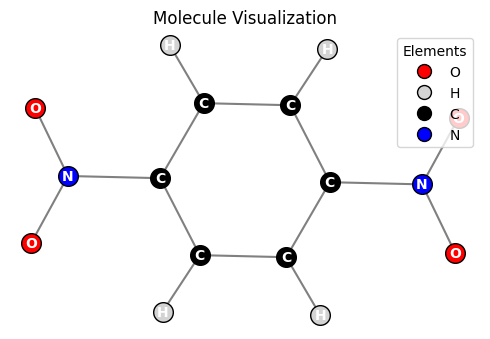

In [8]:
molecule_visualization_image(coords, atomic_numbers,fchk=False)

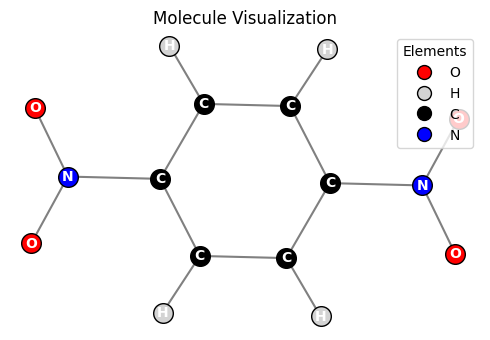

In [9]:
rotated_coords, atomic_numbers = remove_disk(rotated_coords, atomic_numbers, ref= 0.1)
rotated_coords, atomic_numbers = np.array(rotated_coords), np.array(atomic_numbers)
molecule_visualization_image(rotated_coords, atomic_numbers, fchk=False)

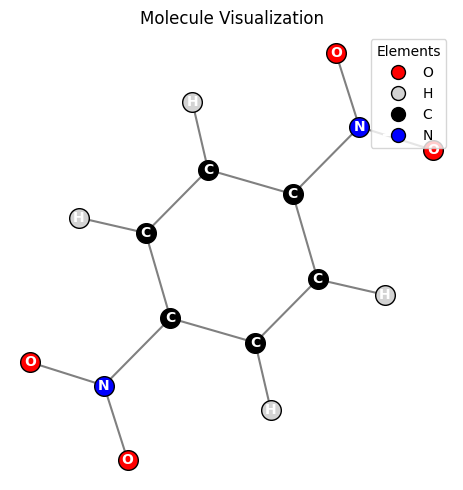

In [10]:
phi, theta, psi = normal_to_zyz_ters(normal)
#phi, theta, psi = normal_and_ref_to_zyz(normal, np.array([1,0,0]))
rotated_coords, R = rotation_zyz_ters(phi, theta, psi, coords)
rotated_coords, atomic_numbers = remove_disk(rotated_coords, atomic_numbers, ref= 1)
rotated_coords, atomic_numbers = np.array(rotated_coords), np.array(atomic_numbers)
molecule_visualization_image(rotated_coords, atomic_numbers, fchk=False)

## 1. PCA-based variance fraction
As you already computed the covariance matrix
$C = \frac{1}{N}\sum_{i}(\mathbf{r}_i-\bar{\mathbf{r}})(\mathbf{r}_i-\bar{\mathbf{r}})^T$
you got three eigenvalues $\lambda_1 \geq \lambda_2 \geq \lambda_3$. They measure the variance of your point-cloud along three orthogonal axes: the first two lie in the plane, the third is perpendicular. A natural "percent planarity" is
$\text{Planarity (\%)} = \frac{\lambda_1+\lambda_2}{\lambda_1+\lambda_2+\lambda_3} \times 100\%.$
* If your points lie perfectly in a plane, $\lambda_3=0$ and planarity = 100%.
* If they are fully 3D, all three eigenvalues are equal, and planarity = 2/3 ≈ 67%.

## 2. RMS-distance from the plane
Alternatively, measure the root‐mean‐square deviation (RMSD) of all atoms from your fitted plane:
1. For each atom $\mathbf{r}_i$, compute its signed distance to the plane
$d_i = \frac{\mathbf{n} \cdot (\mathbf{r}_i-\bar{\mathbf{r}})}{\|\mathbf{n}\|}.$
2. Compute the RMS distance 
$\text{RMSD} = \sqrt{\frac{1}{N}\sum_i d_i^2}$
3. Normalize by a characteristic length scale—commonly the overall span of your molecule in the plane, e.g.
$L = \sqrt{\lambda_1+\lambda_2}$
(the standard deviation of the points within the plane). Then define
$\text{Planarity (\%)} = \left(1 - \frac{\text{RMSD}}{L}\right)\times 100\%.$
If RMSD = 0, planarity = 100%; if RMSD becomes comparable to in-plane spread, planarity drops toward zero.

In [11]:

def planarity(eigvals, eigvecs, X):
    # sort descending 
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]


    # PCA-based planarity
    planarity_pca = 100*(eigvals[0] + eigvals[1])/eigvals.sum()
    


    # RMSD based planarity
    normal = eigvecs[:, 2] # eigenvector for smallest eigenvalue
    d = (X@normal)/np.linalg.norm(normal)
    rmsd = np.sqrt(np.mean(d**2))
    L = np.sqrt(eigvals[0] + eigvals[1])
    planarity_rms = 100*(1-rmsd/L)
    

    return planarity_pca, planarity_rms, rmsd


planarity_pca, planarity_rms,rmsd = planarity(eigvals, eigvecs, X)
print(f"PCA planarity = {planarity_pca:.2f} %")
print(f"RMSD planarity = {planarity_rms:.2f}%")
print(f"RMSD = {rmsd:.4f} Angstroms")

PCA planarity = 100.00 %
RMSD planarity = 99.99%
RMSD = 0.0002 Angstroms


In [12]:
rotated_coords

array([[-1.63075386, -3.18790011,  0.04645843],
       [ 3.15652567,  1.6611652 , -0.31859251],
       [-3.15646276, -1.66111577,  0.31882096],
       [ 1.63082052,  3.18793121, -0.04641033],
       [-2.00053945, -2.02635729,  0.15257987],
       [ 2.00055279,  2.02635829, -0.15251043],
       [-0.95888023, -0.97123187,  0.0730165 ],
       [ 0.95875893,  0.97114476, -0.07320164],
       [ 0.36935351, -1.35414078, -0.11617418],
       [ 1.34723939, -0.36370044, -0.19051255],
       [-1.34726871,  0.36368267,  0.19035137],
       [-0.36940405,  1.35414691,  0.11598375],
       [ 0.61518026, -2.41128596, -0.20108113],
       [ 2.39877469, -0.60472509, -0.33655826],
       [-2.39872231,  0.60473214,  0.33709337],
       [-0.61508997,  2.4112494 ,  0.20156161]])

In [13]:
eigvals, eigvecs, X = pca(coords)

planarity_pca, planarity_rms, rmsd = planarity(eigvals, eigvecs, X)
print(f"PCA planarity = {planarity_pca:.2f} %")
print(f"RMSD planarity = {planarity_rms:.2f}%")

PCA planarity = 100.00 %
RMSD planarity = 99.99%


In [26]:
def check_planar_files(directory):
    #files = glob.glob(f"{directory}/*.fchk")

    dir = Path(directory)
    files = list(dir.rglob("*.fchk"))
    names = []  # To store file names

    count = 0

    planar_dir = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk/'
    os.makedirs(planar_dir, exist_ok=True)

    for file in files:
        
        coords, atomic_numbers = read_fchk(file)
        if len(atomic_numbers) == 0 or len(coords) == 0:
            print(file)
            #os.remove(file)
            continue
        
        eigvals, eigvecs, X = pca(coords)
        planarity_pca, planarity_rms, rmsd = planarity(eigvals, eigvecs, X)

        if rmsd < 0.1:
            shutil.copy(file, os.path.join(planar_dir, os.path.basename(file)))
            count += 1

        names.append(os.path.basename(file))
    
    print(f"Total_files: {len(files)}, Planar files: {count}")



fchk_dir = '/scratch/phys/sin/sethih1/data_files/third_group/'

check_planar_files(fchk_dir)
            



KeyboardInterrupt: 

In [60]:
fchk_dir = '/scratch/phys/sin/sethih1/data_files/third_group/part1'

check_planar_files(fchk_dir)

Total_files: 688, Planar files: 26


Total_files: 1455, Mean RMSD: 0.0038, Std RMSD: 0.0084


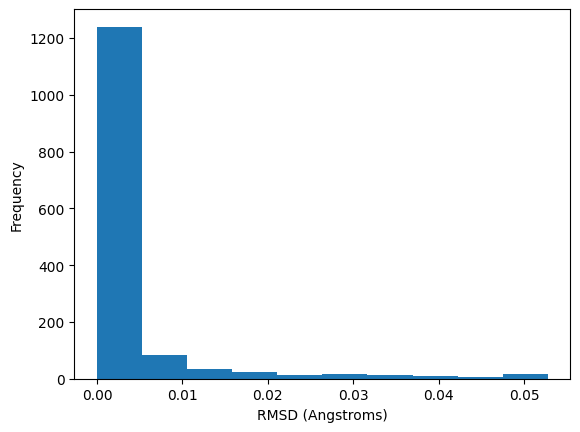

In [14]:
def check_npz_files(directory):
    #files = glob.glob(f"{directory}/*.fchk")

    dir = Path(directory)
    files = list(dir.glob("*.npz"))
    names = []  # To store file names

    count = 0
    rmsds = []


    for file in files:
        
        coords, atomic_numbers = read_npz(file)
        if len(atomic_numbers) == 0 or len(coords) == 0:
            print(file)
            #os.remove(file)
            continue
        
        eigvals, eigvecs, X = pca(coords)
        planarity_pca, planarity_rms, rmsd = planarity(eigvals, eigvecs, X)
        rmsds.append(rmsd)

    
    plt.hist(rmsds, bins=10)
    plt.xlabel('RMSD (Angstroms)')
    plt.ylabel('Frequency')

    print(f"Total_files: {len(files)}, Mean RMSD: {np.mean(rmsds):.4f}, Std RMSD: {np.std(rmsds):.4f}")





npz_dir = '/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split_images_ters/'

check_npz_files(npz_dir)
            

